# 1. Balanced Default Credit Card Dataset

#### Importing Packages

In [93]:
import numpy as np
import pandas as pd
import itertools
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#### Importing Dataset

In [94]:
data=pd.read_csv('UCI_Credit_card.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null float64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null float64
BILL_AMT2                     30000 non-null float64
BILL_AMT3                     30000 non-null float64
BILL_AMT4                     30000 non-null float64
BILL_AMT5                     30000 non-null float64
BILL_AMT6   

In [56]:
data['default_payment_next_month'].value_counts()

0    23364
1     6636
Name: default_payment_next_month, dtype: int64

#### Upsampling Minority Class (default_payment_next_month=1)

In [59]:
##SOURCE: https://elitedatascience.com/imbalanced-classes

In [60]:
from sklearn.utils import resample

In [62]:
#seperation of majority and minority class

data_maj=data[data.default_payment_next_month==0]
data_min=data[data.default_payment_next_month==1]

# upsampling of minority class
data_min_upsample= resample(data_min, replace=True, n_samples=23364, random_state=123)

#concatenation with majority class
data_upsampled = pd.concat([data_maj, data_min_upsample])

#new class count
data_upsampled.default_payment_next_month.value_counts()

1    23364
0    23364
Name: default_payment_next_month, dtype: int64

#### Splitting Data between Test and Train

In [82]:
X = data_upsampled.values[:,1:-1]
y = data_upsampled.values[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)

#### ROC and Confusion Matrix Utility Functions

In [83]:
# source : http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def display_roc(classifier, X, y, number_of_fold=10):
    cv = StratifiedKFold(n_splits=10)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i=0
    for train, test in cv.split(X,y):
        classifier.fit(X[train], y[train])
        y_predicted = classifier.predict(X[test])
        fpr, tpr, thresholds = metrics.roc_curve(y[test], y_predicted)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC visualization')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
def display_accuracy_analysis_and_confusion_matrix(y_test, y_predicted, classes_name, confusion_matrix_title):
    print ('Classification accuracy is :', metrics.accuracy_score(y_test, y_predicted, normalize = True) * 100, '%')
    print ('Null accuracy is :', max(y_test.mean(), 1 - y_test.mean()) * 100, '%')
    print ('Classification error is :', (1- metrics.accuracy_score(y_test, y_predicted, normalize = True)) * 100, '%')
    print ('Sensitivity is :', metrics.recall_score(y_test, y_predicted) * 100, '%')
    confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
    plot_confusion_matrix(confusion_matrix, classes=classes_name, normalize=False, title=confusion_matrix_title)
    plt.show()

#### Random Forest with minimum leaf=5 and number of estimators=500

In [65]:
#with thresold 0.5
randomf = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)
randomf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Classification accuracy is : 87.3354516568 %
Null accuracy is : 50.1199662797 %
Classification error is : 12.6645483432 %
Sensitivity is : 89.2741622461 %


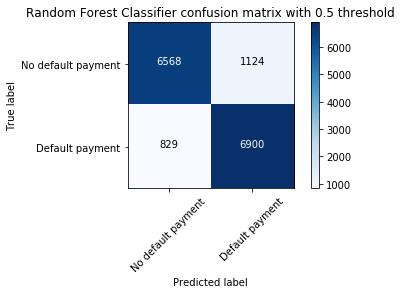

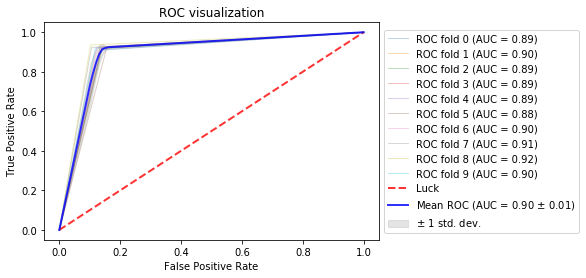

In [66]:
#with thresold 0.5
randomf = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)
randomf.fit(X_train,y_train)
y_predicted=randomf.predict(X_test)
display_accuracy_analysis_and_confusion_matrix(y_test, y_predicted, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.5 threshold')

display_roc(RandomForestClassifier(n_estimators=500, min_samples_leaf=5), X, y)

Classification accuracy is : 99.9962696112 %
Null accuracy is : 50.0564887449 %
Classification error is : 0.00373038881309 %
Sensitivity is : 100.0 %


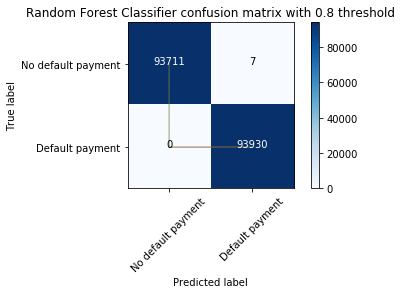

Classification accuracy is : 99.9435112551 %
Null accuracy is : 50.0564887449 %
Classification error is : 0.056488744884 %
Sensitivity is : 100.0 %


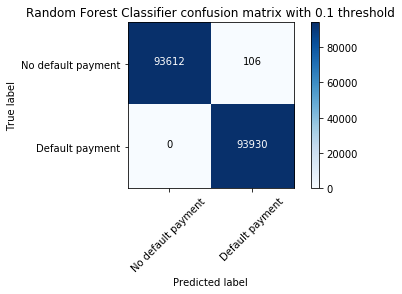

Classification accuracy is : 99.9973354366 %
Null accuracy is : 50.0564887449 %
Classification error is : 0.00266456343793 %
Sensitivity is : 100.0 %


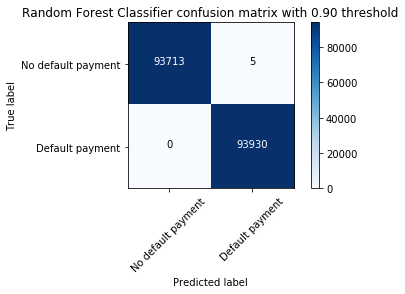

In [84]:
# Testing other threshold than 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)
randomf2 = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)
randomf2.fit(X_train,y_train)

y_predicted = randomf2.predict_proba(X_test)
y_test_predictions_high_precision = y_predicted[:,1] > 0.8
y_test_predictions_high_recall = y_predicted[:,1] > 0.1
y_test_predictions_suggested_by_AUC = y_predicted[:,1] > 0.90

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_precision, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.8 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_recall, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.1 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_suggested_by_AUC, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.90 threshold')


##### Random Forest with minimum leaf=10 and number of estimators=1000

Classification accuracy is : 99.9872100955 %
Null accuracy is : 50.0564887449 %
Classification error is : 0.012789904502 %
Sensitivity is : 100.0 %


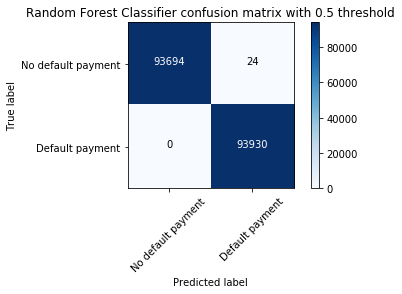

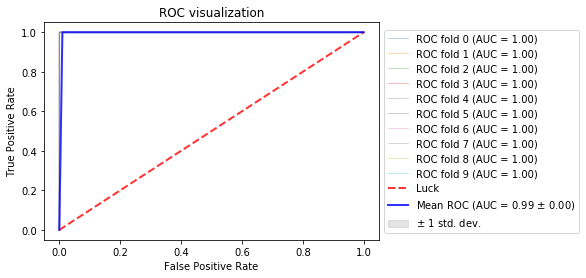

Classification accuracy is : 99.9946708731 %
Null accuracy is : 50.0564887449 %
Classification error is : 0.00532912687585 %
Sensitivity is : 100.0 %


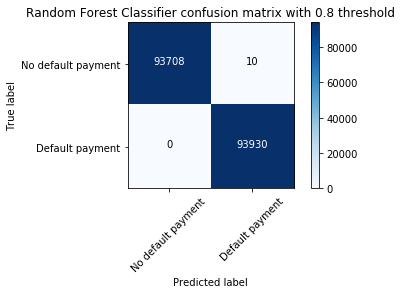

Classification accuracy is : 99.9014111528 %
Null accuracy is : 50.0564887449 %
Classification error is : 0.0985888472033 %
Sensitivity is : 100.0 %


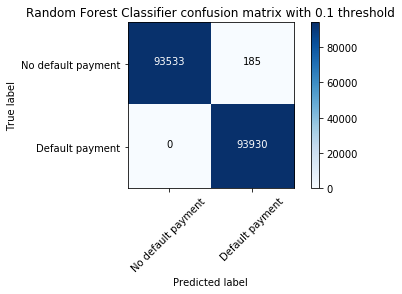

Classification accuracy is : 99.9952037858 %
Null accuracy is : 50.0564887449 %
Classification error is : 0.00479621418826 %
Sensitivity is : 100.0 %


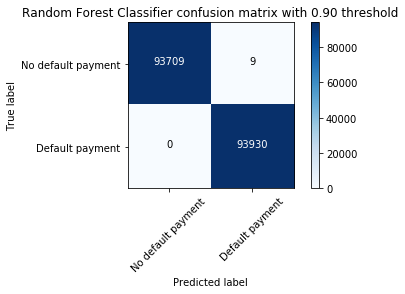

In [85]:
#with thresold 0.5
randomf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=10)
randomf.fit(X_train,y_train)
y_predicted=randomf.predict(X_test)
display_accuracy_analysis_and_confusion_matrix(y_test, y_predicted, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.5 threshold')

display_roc(RandomForestClassifier(n_estimators=1000, min_samples_leaf=10), X, y)

# Testing other threshold than 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)
randomf2 = RandomForestClassifier(n_estimators=1000, min_samples_leaf=10)
randomf2.fit(X_train,y_train)

y_predicted = randomf2.predict_proba(X_test)
y_test_predictions_high_precision = y_predicted[:,1] > 0.8
y_test_predictions_high_recall = y_predicted[:,1] > 0.1
y_test_predictions_suggested_by_AUC = y_predicted[:,1] > 0.90

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_precision, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.8 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_recall, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.1 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_suggested_by_AUC, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.90 threshold')


# 2. Balanced Credit Card Fraud Dataset

#### Importing Datset

In [86]:
data2=pd.read_csv('creditcard.csv')
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [87]:
data2['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

#### Upsampling Minority Class (Class=1)

In [88]:
##SOURCE: https://elitedatascience.com/imbalanced-classes
#seperation of majority and minority class

data2_maj=data2[data2.Class==0]
data2_min=data2[data2.Class==1]

# upsampling of minority class
data2_min_upsample= resample(data2_min, replace=True, n_samples=284315, random_state=123)

#concatenation with majority class
data2_upsampled = pd.concat([data2_maj, data2_min_upsample])

#new class count
data2_upsampled.Class.value_counts()

1    284315
0    284315
Name: Class, dtype: int64

#### Split data between Test and Train

In [89]:
X = data2_upsampled.values[:,1:-1]
y = data2_upsampled.values[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)

#### Random Forest with minimum leaf=5 and number of estimators=500

In [90]:
#with thresold 0.5
randomf = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)
randomf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Classification accuracy is : 99.9925392224 %
Null accuracy is : 50.0564887449 %
Classification error is : 0.00746077762619 %
Sensitivity is : 100.0 %


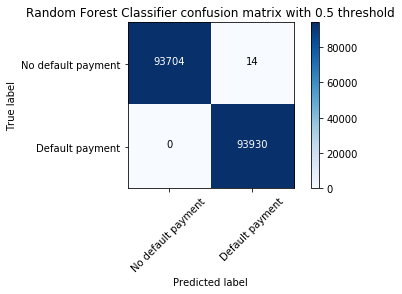

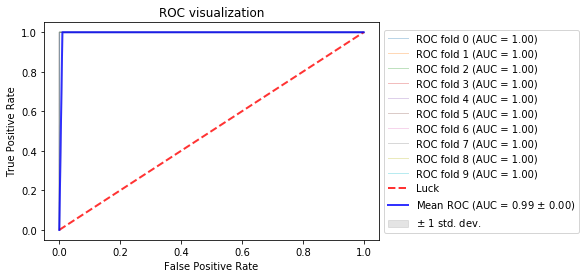

Classification accuracy is : 99.9962696112 %
Null accuracy is : 50.0564887449 %
Classification error is : 0.00373038881309 %
Sensitivity is : 100.0 %


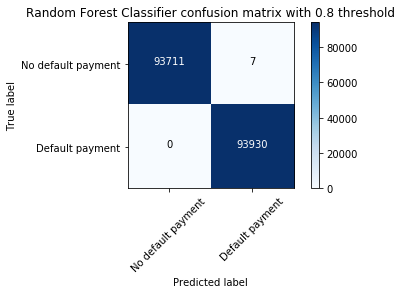

Classification accuracy is : 99.9440441678 %
Null accuracy is : 50.0564887449 %
Classification error is : 0.0559558321965 %
Sensitivity is : 100.0 %


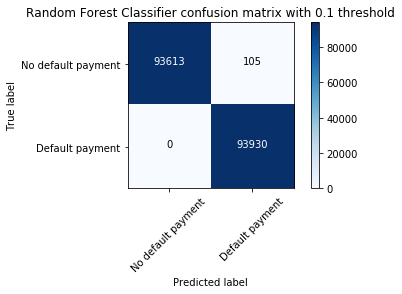

Classification accuracy is : 99.9978683492 %
Null accuracy is : 50.0564887449 %
Classification error is : 0.00213165075034 %
Sensitivity is : 100.0 %


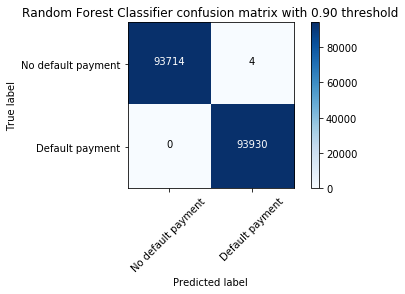

In [91]:
#with thresold 0.5
randomf = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)
randomf.fit(X_train,y_train)
y_predicted=randomf.predict(X_test)
display_accuracy_analysis_and_confusion_matrix(y_test, y_predicted, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.5 threshold')

display_roc(RandomForestClassifier(n_estimators=500, min_samples_leaf=5), X, y)

# Testing other threshold than 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)
randomf2 = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)
randomf2.fit(X_train,y_train)

y_predicted = randomf2.predict_proba(X_test)
y_test_predictions_high_precision = y_predicted[:,1] > 0.8
y_test_predictions_high_recall = y_predicted[:,1] > 0.1
y_test_predictions_suggested_by_AUC = y_predicted[:,1] > 0.90

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_precision, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.8 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_recall, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.1 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_suggested_by_AUC, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.90 threshold')


#### Random Forest with minimum leaf=10 and number of estimators=1000

Classification accuracy is : 99.9877430082 %
Null accuracy is : 50.0564887449 %
Classification error is : 0.0122569918145 %
Sensitivity is : 100.0 %


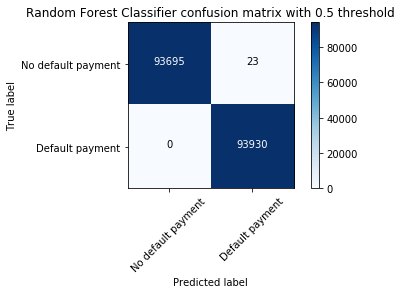

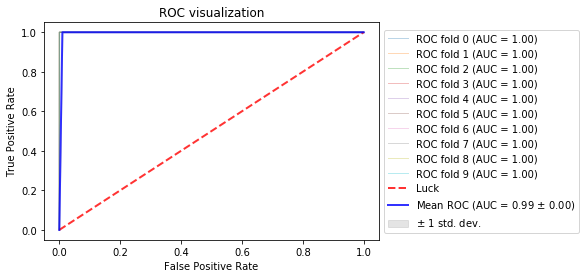

Classification accuracy is : 99.9946708731 %
Null accuracy is : 50.0564887449 %
Classification error is : 0.00532912687585 %
Sensitivity is : 100.0 %


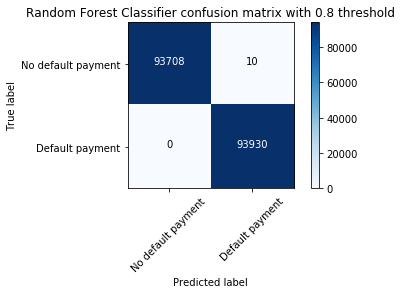

Classification accuracy is : 99.9067402797 %
Null accuracy is : 50.0564887449 %
Classification error is : 0.0932597203274 %
Sensitivity is : 100.0 %


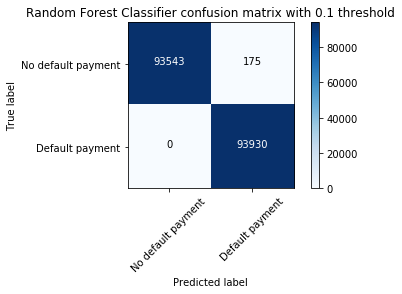

Classification accuracy is : 99.9952037858 %
Null accuracy is : 50.0564887449 %
Classification error is : 0.00479621418826 %
Sensitivity is : 100.0 %


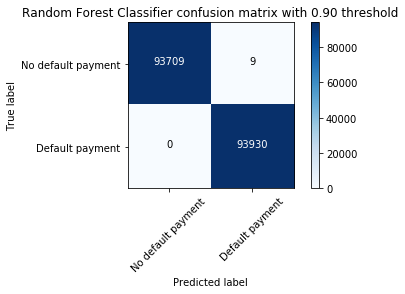

In [92]:
#with thresold 0.5
randomf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=10)
randomf.fit(X_train,y_train)
y_predicted=randomf.predict(X_test)
display_accuracy_analysis_and_confusion_matrix(y_test, y_predicted, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.5 threshold')

display_roc(RandomForestClassifier(n_estimators=1000, min_samples_leaf=10), X, y)

# Testing other threshold than 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)
randomf2 = RandomForestClassifier(n_estimators=1000, min_samples_leaf=10)
randomf2.fit(X_train,y_train)

y_predicted = randomf2.predict_proba(X_test)
y_test_predictions_high_precision = y_predicted[:,1] > 0.8
y_test_predictions_high_recall = y_predicted[:,1] > 0.1
y_test_predictions_suggested_by_AUC = y_predicted[:,1] > 0.90

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_precision, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.8 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_recall, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.1 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_suggested_by_AUC, 
                        ['No default payment', 'Default payment'], 'Random Forest Classifier confusion matrix with 0.90 threshold')
